In [2]:
import pandas as pd 
import numpy as np 
import requests
# for history data in yahoo finance
import yfinance as yf

#import Beautifull soap for web scrapping
from bs4 import BeautifulSoup

#Visuals 
import matplotlib.pyplot as plt 
import seaborn as se 

*  <b>Goal</b> : extract the revenue data for Tesla and GameStop and build a dashboard to compare the price of the stock vs the revenue. 
<hr>

#### Some notes

* Revenue is the total amount of income generated by the sale of goods or services related to the company's primary operations
*  Stock Price: This is the current market value of a single share of a company's stock. It is determined by the supply and demand dynamics in the stock market.
*  Price-to-Sales (P/S) Ratio: The P/S ratio is calculated by dividing the stock price by the revenue per share. 
*  The P/S ratio provides insights into how the market values a company's revenue. A lower P/S ratio may suggest that the stock is undervalued relative to its revenue, while a higher P/S ratio could indicate the opposite.

### Extracting Revenue Data

In [3]:
# making class financial to get annual revenue of each company from stock analysis.com 
# scrapping with 
class revenue : 
    def __init__(self,company_name): 
        self.comp = company_name 
        self.data = self.scrap(company_name)
        
    def scrap(self,company_name ) : 
        url = f"https://stockanalysis.com/stocks/{company_name}/revenue/"
        page = requests.get(url)

        soup = BeautifulSoup(page.text,"html")
        revenues = soup.find_all("table", class_ = "svelte-1jtwn20")
        columns = ["Year End","Revenue","change","growth"]
        year = []
        revenue =[]
        change =[]
        growth = []

        for i in revenues[0].find_all("tr") : 
            try : 
                row = i.find_all("td") 
                year.append(row[0].text)
                revenue.append(row[1].text)
                change.append(row[2].text)
                growth.append(row[3].text)
            except : pass
            
        return pd.DataFrame(np.array([year,revenue,change,growth]).T,columns=columns)
        

In [4]:
tesla = revenue("tsla")
tesla_revenue = tesla.data.copy()
tesla_revenue.tail()


,Year End,Revenue,change,growth
12,"Dec 31, 2011",204.24M,87.50M,74.95%
13,"Dec 31, 2010",116.74M,4.80M,4.29%
14,"Dec 31, 2009",111.94M,97.20M,659.35%
15,"Dec 31, 2008",14.74M,14.67M,"20,094.52%"
16,"Dec 31, 2007",73.00K,-,-


### Tesla Revenue

In [5]:
# Tesla , ticker sample is : tsla (it's name in the stock)

# modify datetime 
tesla_revenue["Year End"] = pd.to_datetime(tesla_revenue["Year End"])
tesla_revenue["Year"] = tesla_revenue["Year End"].dt.year
tesla_revenue.head()



,Year End,Revenue,change,growth,Year
0,2023-12-31,96.77B,15.31B,18.80%,2023
1,2022-12-31,81.46B,27.64B,51.35%,2022
2,2021-12-31,53.82B,22.29B,70.67%,2021
3,2020-12-31,31.54B,6.96B,28.31%,2020
4,2019-12-31,24.58B,3.12B,14.52%,2019


In [6]:
def numeric_revenue(i) : 
    if "B" in i : 
        return float(i[:-1])*10**9
    elif "M" in i : 
        return float(i[:-1])*10**6
    else : 
        return float(i[:-1])*10**3
tesla_revenue["Revenue"] = tesla_revenue["Revenue"].apply(numeric_revenue)

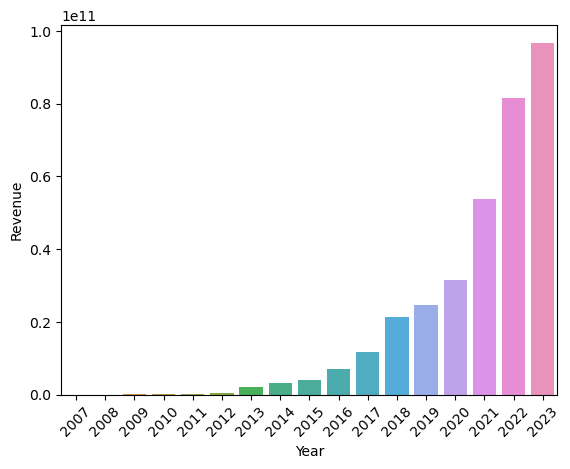

In [7]:
tesla_revenue.sort_values(by="Revenue",ascending=False,inplace=True)
se.barplot(x="Year",y="Revenue",data=tesla_revenue)
plt.xticks(rotation=45);




### Game Stop Revenue

In [14]:
#Game stop , ticker name is gme
Game_stop = revenue("gme")
gme_revenue = Game_stop.data.copy()

# modify datetime 
gme_revenue["Year End"] = pd.to_datetime(gme_revenue["Year End"])
gme_revenue["Year"] = gme_revenue["Year End"].dt.year
gme_revenue.tail()

,Year End,Revenue,change,growth,Year
20,2003-01-31,1.35B,231.65M,20.66%,2003
21,2002-01-31,1.12B,364.44M,48.16%,2002
22,2001-01-31,756.70M,203.56M,36.80%,2001
23,2000-01-31,553.14M,169.78M,44.29%,2000
24,1998-01-31,383.36M,-,-,1998


In [9]:
gme_revenue["Revenue"] = gme_revenue["Revenue"].apply(numeric_revenue)

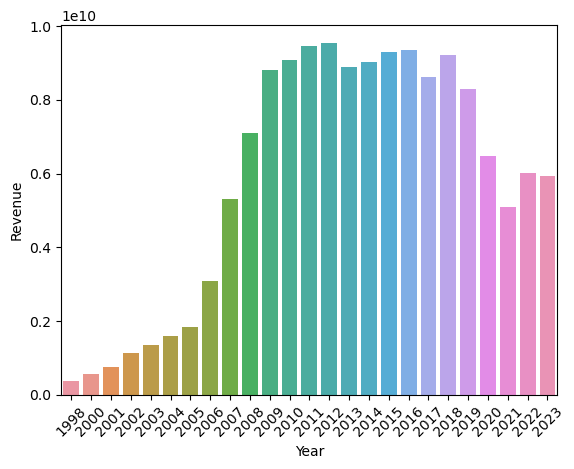

In [10]:
gme_revenue.sort_values(by="Revenue",ascending=False,inplace=True)
se.barplot(x="Year",y="Revenue",data=gme_revenue)
plt.xticks(rotation=45);

<Axes: xlabel='Year', ylabel='Revenue'>

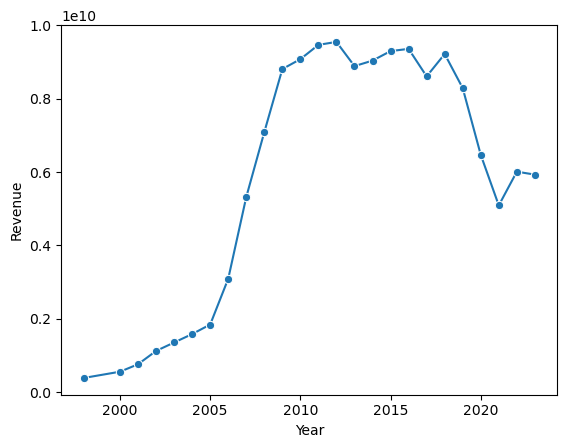

In [11]:
se.lineplot(x="Year",y="Revenue",data=gme_revenue,marker="o")



### Historical Stock Data

In [12]:
class history : 
    def __init__(self,company) : 
        self.company = company 
        self.data = self.get_history(company).reset_index()
        
        
        
    def get_history(self,company) : 
        ticker = yf.Ticker(f"{company}")
        return ticker.history(period='max')


        

### Tesla History

In [13]:
tesla_history = history("tsla").data
tesla_history["Year"] = tesla_history["Date"].dt.year
tesla_mean_stock = tesla_history.groupby('Year')["Close"].mean()
tesla_history.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Year
0,2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,0.0,0.0,2010
1,2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,0.0,0.0,2010
2,2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,0.0,0.0,2010
3,2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,0.0,0.0,2010
4,2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,0.0,0.0,2010


In [20]:
# make new dataset combinig both stockprice an rvenue 
history_revenue = pd.merge(tesla_revenue,tesla_mean_stock,on="Year")

In [21]:
history_revenue["growh"] = history_revenue["growth"].str.replace("%","").astype("float")
history_revenue

,Year End,Revenue,change,growth,Year,Close,growh
0,2023-12-31,9.677000e+10,15.31B,18.80%,2023,217.475240,18.80
1,2022-12-31,8.146000e+10,27.64B,51.35%,2022,263.093081,51.35
2,2021-12-31,5.382000e+10,22.29B,70.67%,2021,259.998162,70.67
3,2020-12-31,3.154000e+10,6.96B,28.31%,2020,96.665689,28.31
4,2019-12-31,2.458000e+10,3.12B,14.52%,2019,18.235347,14.52
5,2018-12-31,2.146000e+10,9.70B,82.51%,2018,21.153995,82.51
6,2017-12-31,1.176000e+10,4.76B,67.98%,2017,20.954420,67.98
7,2016-12-31,7.000000e+09,2.95B,73.01%,2016,13.984484,73.01
8,2015-12-31,4.050000e+09,847.67M,26.50%,2015,15.336193,26.50
9,2014-12-31,3.200000e+09,1.18B,58.85%,2014,14.888606,58.85


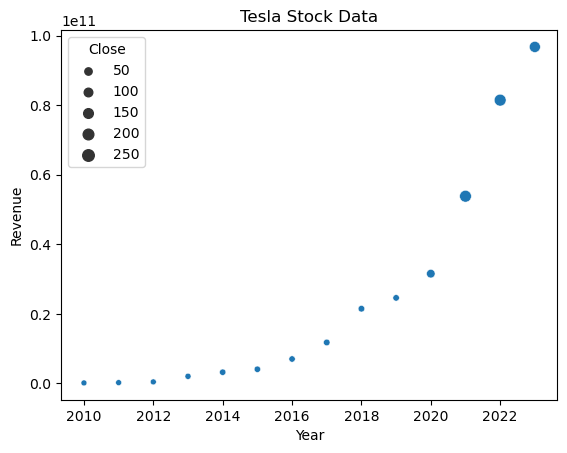

In [24]:
def make_graph(data) : 
    se.scatterplot(data = data ,x = "Year",y="Revenue",size="Close")
    plt.title("Tesla Stock Data")
make_graph(history_revenue)

### Game Stop History

In [15]:
gme_history = history("gme").data
gme_history["Year"] = gme_history["Date"].dt.year
gme_mean_stock = gme_history.groupby('Year')["Close"].mean()

In [17]:
gme_history.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Year
0,2002-02-13 00:00:00-05:00,1.620128,1.693350,1.603296,1.691666,76216000,0.0,0.0,2002
1,2002-02-14 00:00:00-05:00,1.712707,1.716073,1.670626,1.683250,11021600,0.0,0.0,2002
2,2002-02-15 00:00:00-05:00,1.683250,1.687458,1.658002,1.674834,8389600,0.0,0.0,2002
3,2002-02-19 00:00:00-05:00,1.666417,1.666417,1.578047,1.607504,7410400,0.0,0.0,2002
4,2002-02-20 00:00:00-05:00,1.615920,1.662210,1.603296,1.662210,6892800,0.0,0.0,2002


In [35]:
# make new dataset combinig both stockprice an rvenue 
gme_history_revenue = pd.merge(gme_revenue,gme_mean_stock,on="Year")

In [36]:
gme_history_revenue["growth"] = gme_history_revenue["growth"].str.replace("%","").astype("float")
gme_history_revenue

,Year End,Revenue,change,growth,Year,Close
0,2023-01-28,5.93B,-83.50M,-1.39,2023,19.223640
1,2022-01-29,6.01B,920.90M,18.09,2022,29.639691
2,2021-01-30,5.09B,-1.38B,-21.28,2021,42.426686
3,2020-02-01,6.47B,-1.82B,-21.96,2020,1.785366
4,2019-02-02,8.29B,-939.30M,-10.18,2019,1.866594
5,2018-02-03,9.22B,616.70M,7.16,2018,3.377272
6,2017-01-28,8.61B,-755.90M,-8.07,2017,4.512627
7,2016-01-30,9.36B,67.80M,0.73,2016,5.515834
8,2015-01-31,9.30B,256.50M,2.84,2015,7.651819
9,2014-02-01,9.04B,152.80M,1.72,2014,7.265299


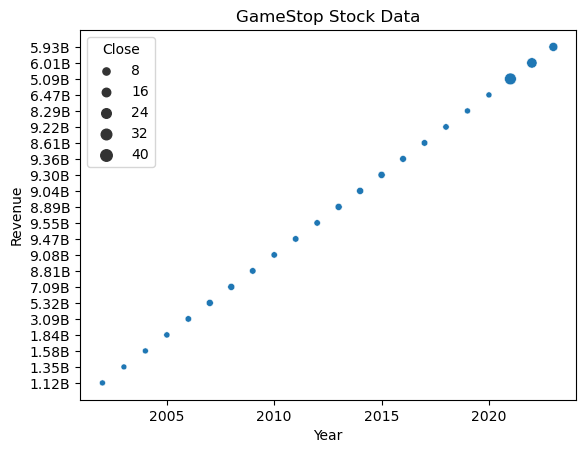

In [38]:
def make_graph(data) : 
    se.scatterplot(data = data ,x = "Year",y="Revenue",size="Close")
    plt.title("GameStop Stock Data")
make_graph(gme_history_revenue)
